## Objective
Test how to extract waveform clustering metrics
![](waveform_clustering_metrics.jpg)

ht1 = time_ht1 = 1st half-trough
ht2 = time_ht2 = 2nd half-trough
P = time_p = time of peak
T = time_t = time of trough
hp = time_hp = time of half peak
P_amp = amp_p = amplitude of peak
T_amp = amp_t = amplitude of trough

In [2]:
%load_ext autoreload
%autoreload

# Update PATH to allow imports
import sys
if "/data/MEAprojects/DLSpikeSorter" not in sys.path:
    sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [3]:
# Load unit templates
TEMPLATES_PATH = "/data/MEAprojects/DLSpikeSorter/2954/spikesort_matlab4/waveforms/templates/templates_average.npy"
##
templates = np.load(TEMPLATES_PATH, mmap_mode="r")

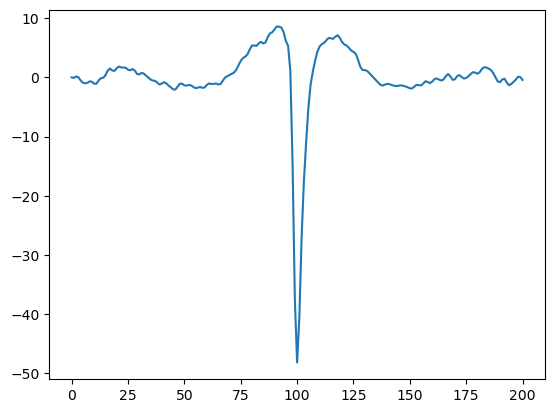

In [4]:
# Pick a unit
UNIT_ID = 0
##
template = templates[UNIT_ID, :, :]
chan_max = np.min(template, axis=0).argmin()
template = template[:, chan_max]
plt.plot(template)
plt.show()

In [5]:
def get_waveform_metrics(waveform, time_t, return_metrics=True):
    # If metrics, return metrics. Else, return points for plotting

    amp_t = waveform[time_t]

    time_p = time_t + np.argmax(waveform[time_t:]) # find_peaks(waveform[time_t:], height=0)[0][0]
    amp_p = waveform[time_p]

    temp_hp = waveform[time_p:]
    amp_hp =  amp_p / 2
    for i in range(temp_hp.size-1):
        y1 = temp_hp[i]
        y2 = temp_hp[i+1]
        if y1 >= amp_hp >= y2:
            time_hp = (amp_hp - y1) / (y2 - y1) + i + time_p
            break
    else:
        time_hp = waveform.size

    amp_ht = amp_t / 2
    time_ht2 = np.interp(amp_ht, waveform[time_t:time_p], range(time_t, time_p))

    time_pp = find_peaks(waveform[:time_t], height=amp_ht)[0][-1]  # Time of first positive peak before trough (pp for prepositive peak)--> time_pp to time_t is non-increasing
    time_ht1 = np.interp(-amp_ht, -waveform[time_pp:time_t], range(time_pp, time_t))

    if return_metrics:
        return time_ht2 - time_ht1, time_p - time_t, time_ht2 - time_t, time_hp - time_p, amp_p / amp_t
    else:
        return (time_ht1, amp_ht), (time_t, amp_t), (time_ht2, amp_ht), (time_p, amp_p), (time_hp, amp_hp)  # For plotting

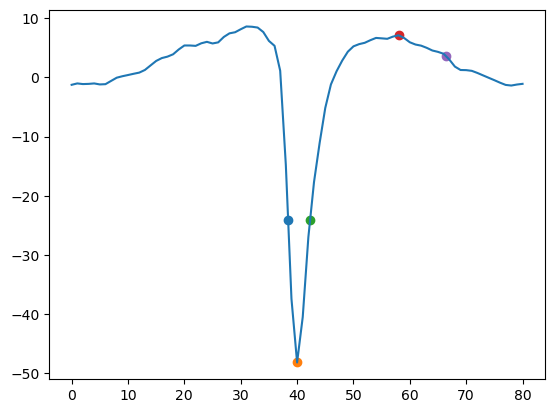

0.1542196273803711


In [9]:
# Window around spike detected by model
N_BEFORE = 40
N_AFTER = 40
## Test getting metrics

# Plot all units
import time
start = time.time()
for uid in range(templates.shape[0]):
    template = templates[uid, :, :]
    if np.all(template == 0): continue

    time_t = template.shape[0] // 2
    chan_max = template[time_t, :].argmin()
    temp = template[time_t - N_BEFORE: time_t + N_AFTER + 1, chan_max]

    plt.plot(temp)
    for x, y in get_waveform_metrics(temp, N_BEFORE, return_metrics=False):
        plt.scatter(x, y)
    plt.show()
    break
print(time.time() - start)

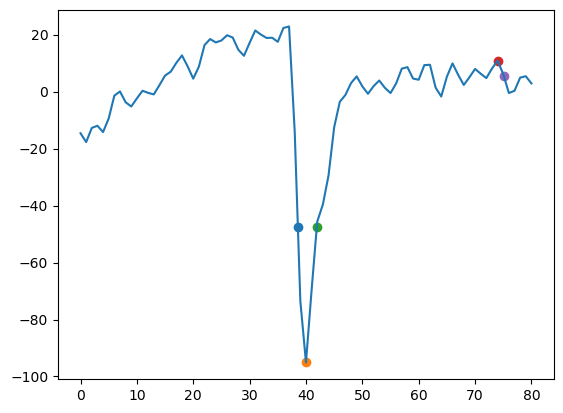

In [10]:
# Test metrics on individual kilosort waveforms (not templates)
UNIT_ID = 8
##
time_t = templates.shape[1] // 2
waveforms = np.load(f"/data/MEAprojects/DLSpikeSorter/2954/spikesort_matlab4/waveforms/waveforms/waveforms_{UNIT_ID}.npy", mmap_mode="r")
chan_max = templates[UNIT_ID, time_t, :].argmin()
for i in range(waveforms.shape[0]):
    waveform = waveforms[i, time_t-N_BEFORE:time_t+N_AFTER + 1, chan_max]
    plt.plot(waveform)
    for (x, y) in get_waveform_metrics(waveform, N_BEFORE, return_metrics=False):
        plt.scatter(x, y)
    plt.show()
    break

Using random seed 23111


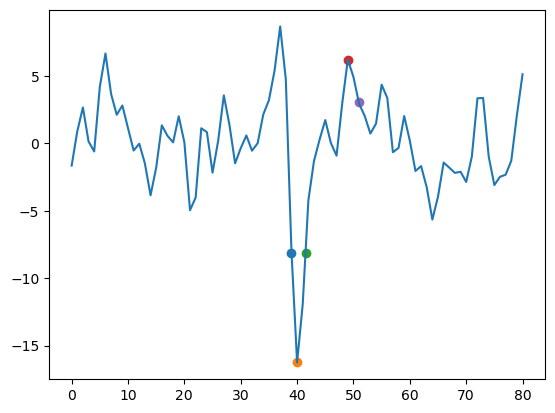

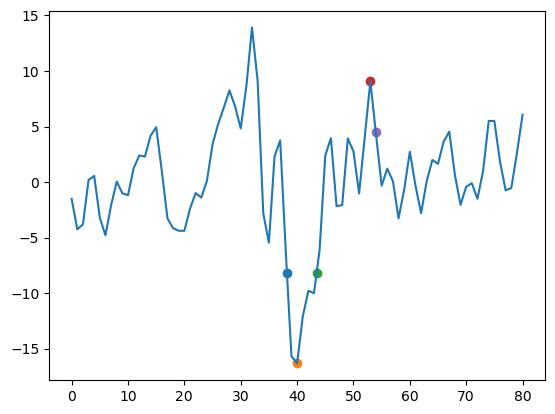

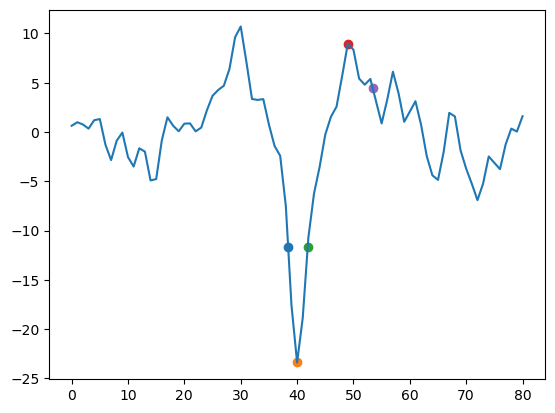

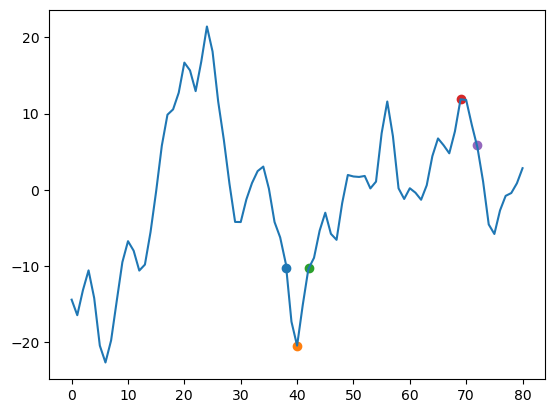

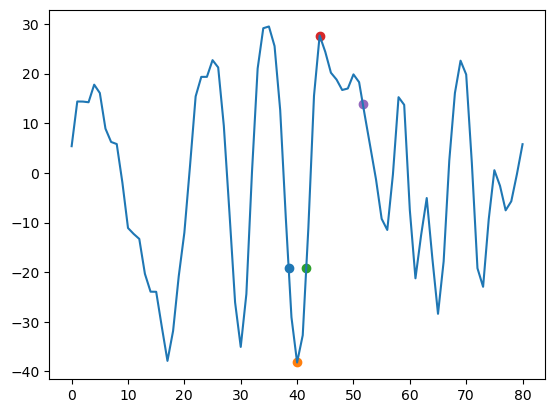

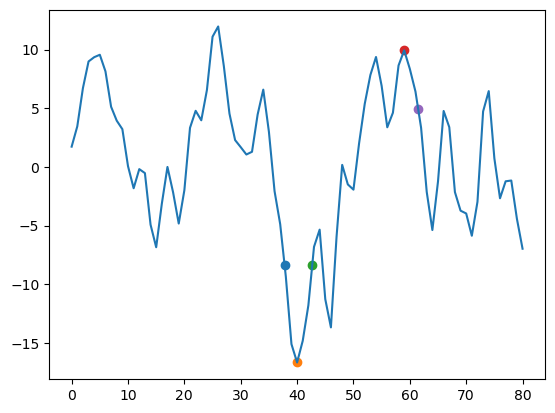

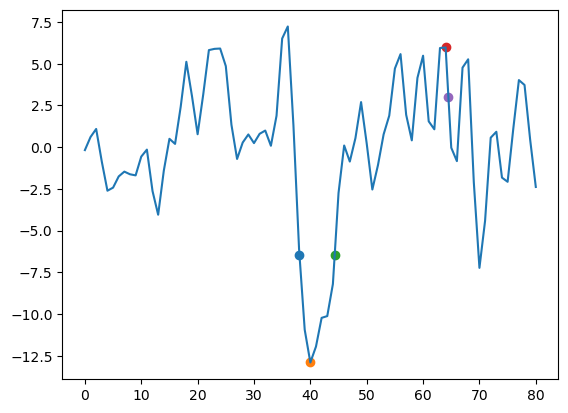

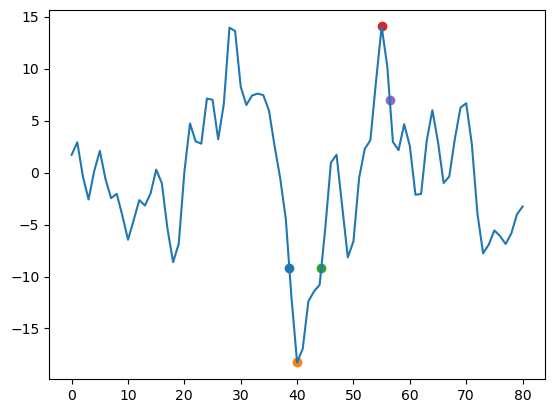

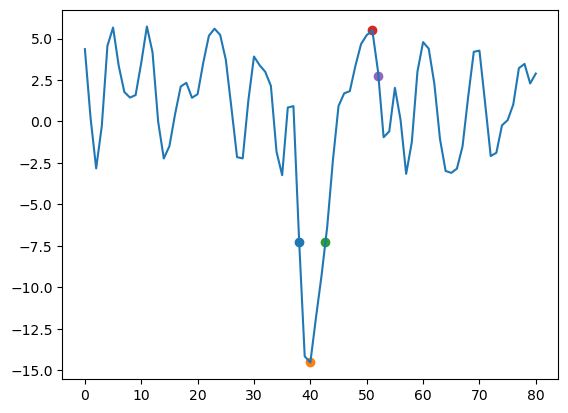

ValueError: array of sample points is empty

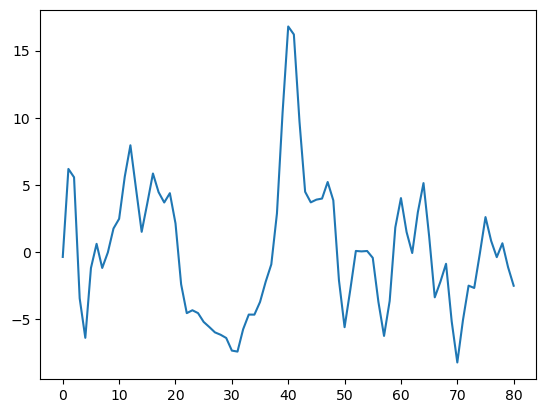

In [15]:
# Test metrics on individual model waveforms
N_BEFORE = N_AFTER = 40
N_PLOTS = 12

from src.utils import random_seed
random_seed(23111)
##
spikes_model = np.load(f"/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2950/230101_133131_959516/log/windows_200_120_spike_times.npy", allow_pickle=True)

from src.analysis.recording import Recording
recording = Recording("/data/MEAprojects/DLSpikeSorter/2950/data.raw.h5", freq_min=300, freq_max=6000, rec_name="2950")

for i in range(N_PLOTS):
    st = None
    while st is None:
        chan = np.random.choice(len(spikes_model))
        if len(spikes_model[chan]) > 0:
            st = np.random.choice(spikes_model[chan])

    st = np.random.choice(spikes_model[chan])
    waveform = recording.get_traces_filt(st-N_BEFORE, st+N_AFTER+1, chan).flatten()
    plt.plot(waveform)
    for (x, y) in get_waveform_metrics(waveform, N_BEFORE, return_metrics=False):
        plt.scatter(x, y)
    plt.show()